In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from samplers import DDPMSampler2d
from diffusers import DDPMDiffuser2d
from utils import display_images, create_gif_from_tensor

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32))
])
mnist_data = torchvision.datasets.MNIST(root="./datasets", train=False, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=25, shuffle=True, num_workers=0)

test_data = iter(data_loader).next()[0].cuda()

In [3]:
T = 1000
model = torch.load("./ckpts/mnist/model_weight_130.pth")
sampler = DDPMSampler2d(torch.linspace(10e-4, 0.02, T).cuda(), model)
diffuser = DDPMDiffuser2d(torch.linspace(10e-4, 0.02, T).cuda())

tensor(3.6130e-05, device='cuda:0', grad_fn=<MeanBackward0>)


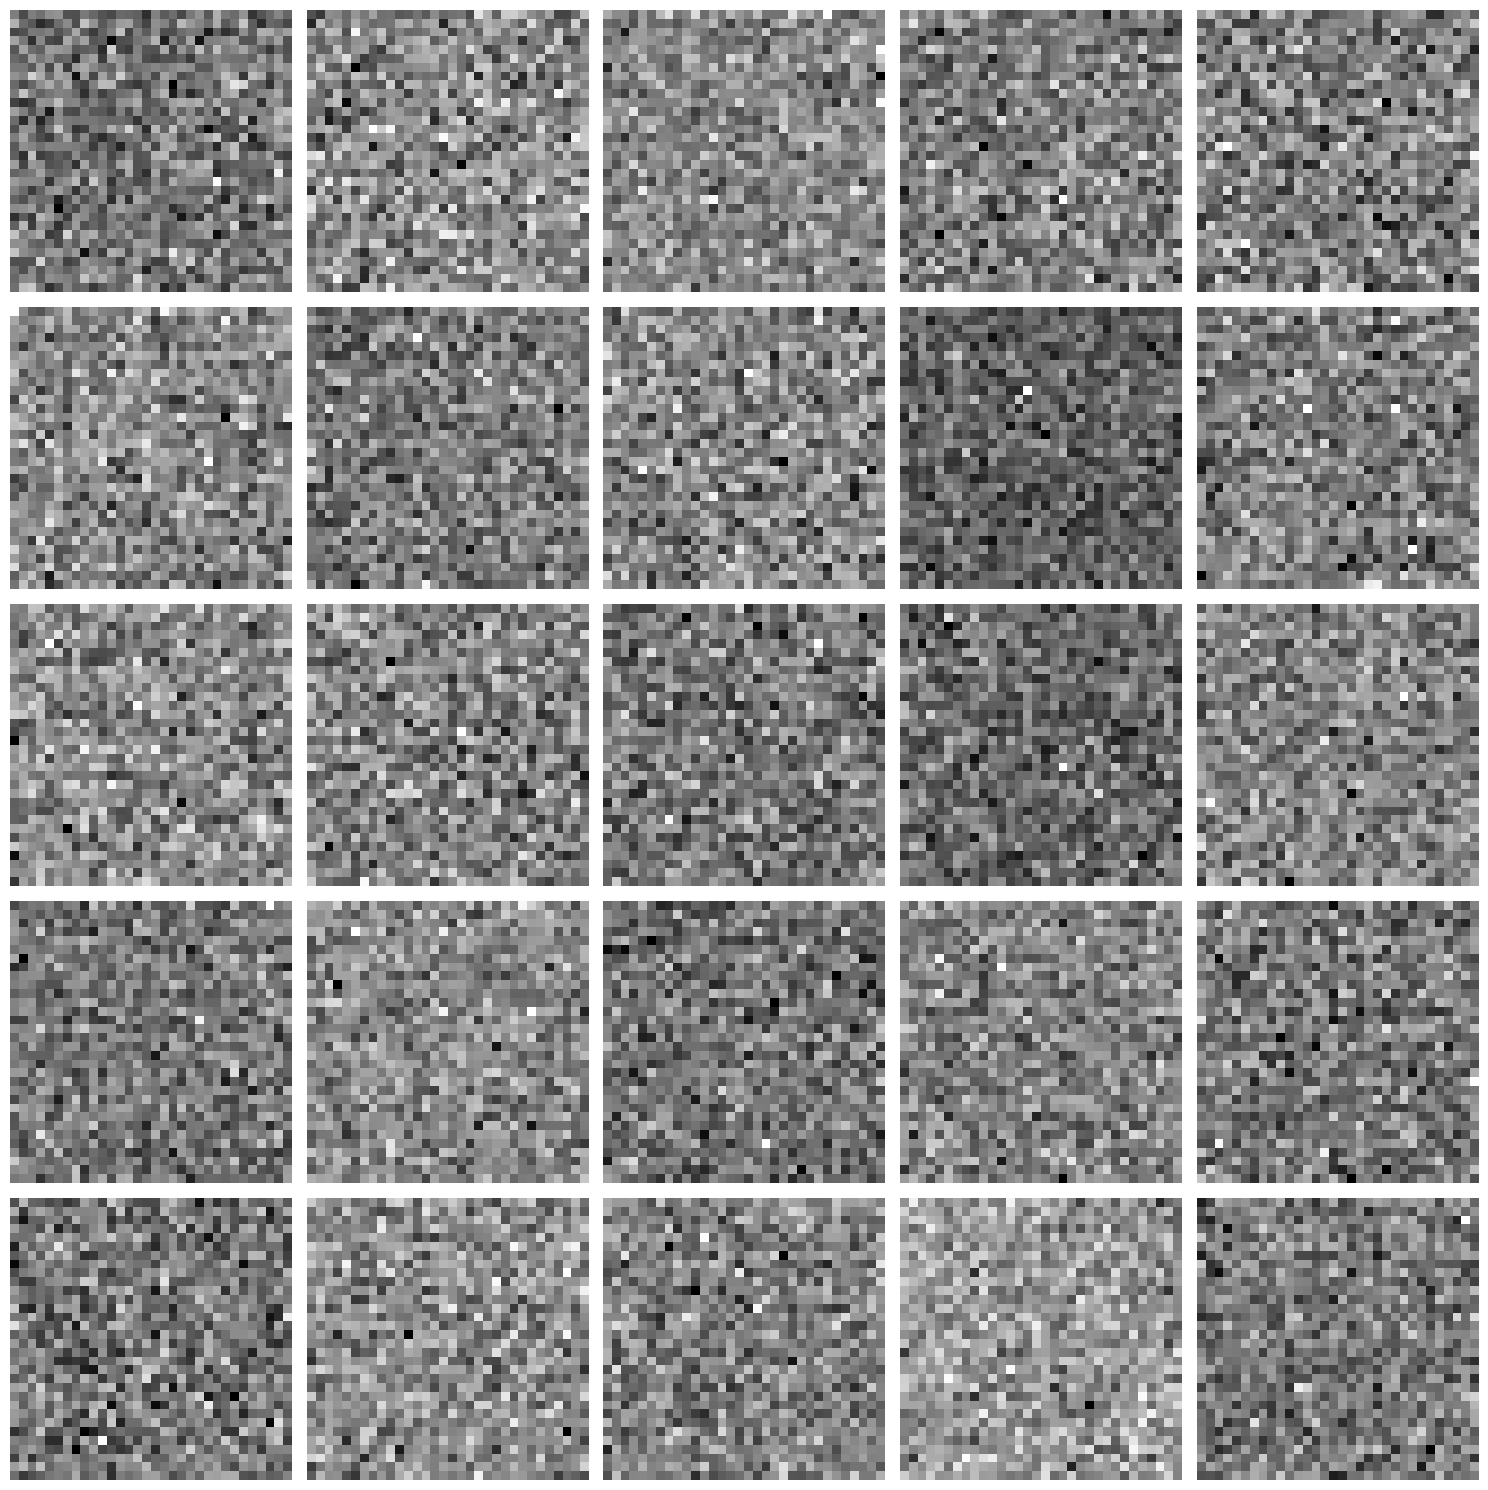

In [4]:
T = 999
t = T * torch.ones(test_data.shape[0]).long().cuda()
test_data_diffused, eps = diffuser.diffuse(test_data, t)
pred_eps = model(test_data_diffused, t)

print(torch.square(pred_eps - eps).mean())

display_images(test_data_diffused.detach().cpu().numpy())
sample = test_data_diffused

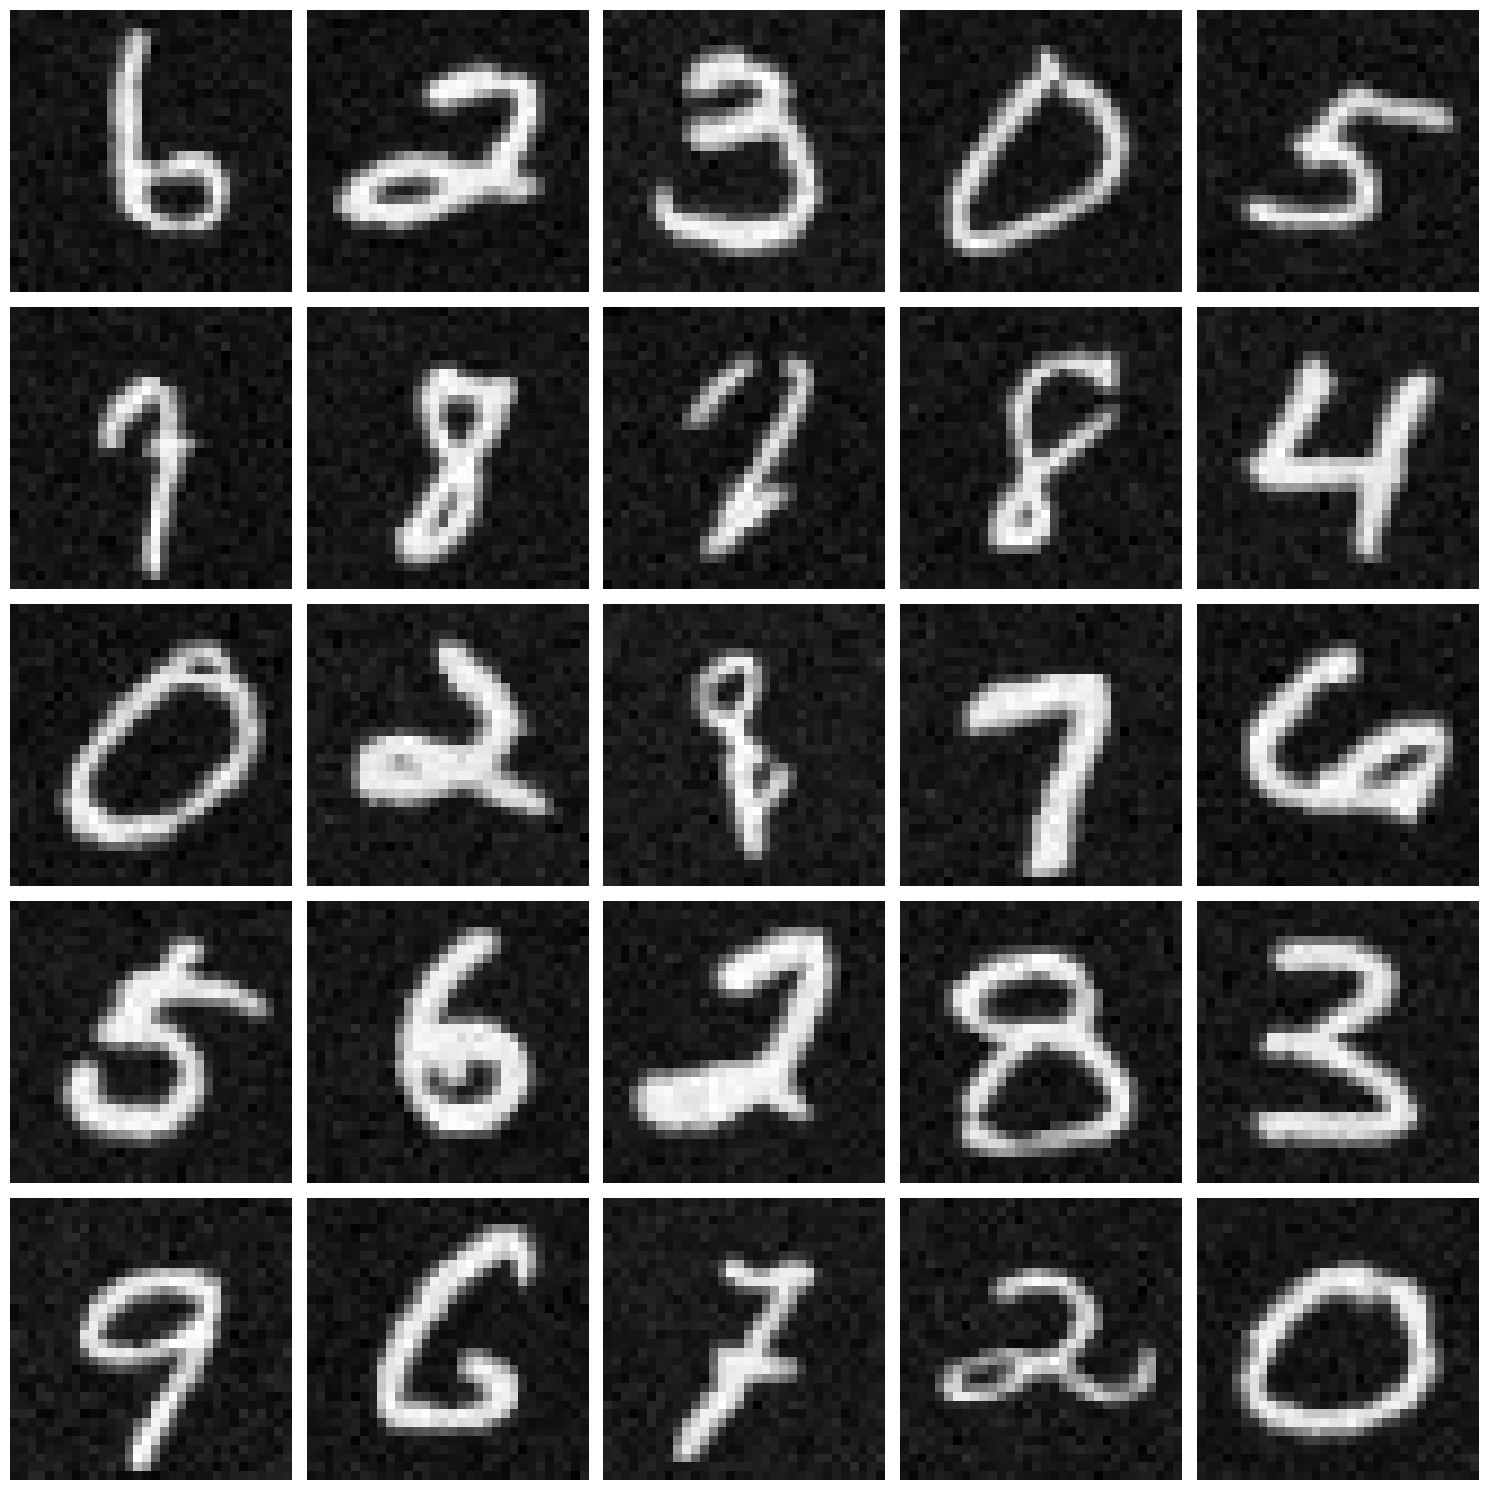

In [5]:
X = torch.zeros(25, T, 1, 32, 32).cuda()
X[:, T-1, :, :, :] = torch.randn(25, 1, 32, 32).cuda()
with torch.no_grad():
    for t in range(T-2, -1, -1):
        times = t  * torch.ones(sample.shape[0]).long().cuda()
        X[:, t, :, :, :] = sampler.sample(X[:, t+1, :, :, :], times)

display_images(X[:, 0, :, :, :].cpu().numpy())

In [14]:
indices = np.arange(0, 100, 2)
indices = np.concatenate((indices, np.arange(200, 400, 50)))
indices = np.concatenate((indices, np.arange(400, 600, 50)))
indices = np.concatenate((indices, np.arange(600, 999, 50)))

indices = list(indices)

X_gif = X[:, indices, :, :, :]
create_gif_from_tensor(X_gif, 'test.gif', duration=16.6, interval=1)

In [8]:
X_gif.shape

torch.Size([25, 203, 1, 32, 32])